Submission Dicoding -  Belajar Machine Learning untuk Pemula

Nama : Chandra Perdiansyah 


Email : chandraperdiansyah@gmail.com


#**Import Library & Fetching Dataset**

In [1]:
import tensorflow as tf
import zipfile,os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, History
!pip install split-folders
import splitfolders 
import shutil
from matplotlib import pyplot as plt

In [2]:
#Fetching Dataset

!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-02-16 08:53:20--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  3.80MB/s    in 82s     

2021-02-16 08:54:43 (3.77 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
# Extrak Dataset file zip
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
base_dir = 'dataset-split'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'val')

#**Membuat direktori dan Split Dataset**

In [5]:
#Split Folder Menggunakan library splitfolders 

splitfolders.ratio('/tmp/rockpaperscissors', output="dataset-split", seed=42, ratio=(0.6,0.4), group_prefix=None)

Copying files: 2189 files [00:00, 3785.05 files/s]


In [6]:
#Hapus file dan Folder yang tidak perlu
#Tujuannya supaya dapet 3 Clases

shutil.rmtree('dataset-split/train/rps-cv-images')

shutil.rmtree('dataset-split/val/rps-cv-images')

os.listdir(train_dir)


['paper', 'rock', 'scissors']

In [7]:
#Cek berapa banyak file dalam path

file_train_count = sum(len(files) for _, _, files in os.walk(r'dataset-split/train'))
file_val_count = sum(len(files) for _, _, files in os.walk(r'dataset-split/val'))

print("Train :", file_train_count)
print("Val :", file_val_count)


Train : 1312
Val : 876


#**Augmentasi dan Image Data Generator**

In [42]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
)

In [43]:
train_generator = datagen.flow_from_directory(
  train_dir, 
  target_size=(150, 150),
  batch_size=32, 
  color_mode='rgb', 
  class_mode='categorical', 
  shuffle = True, 
  seed=42) 
  
validation_generator = datagen.flow_from_directory(
  validation_dir,
  target_size=(150, 150),
  batch_size=32,
  color_mode='rgb',
  class_mode='categorical',
  shuffle = True,
  seed=42)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [44]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation= 'relu'),
  tf.keras.layers.Dense(3, activation= 'softmax')
])

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

In [45]:
# Callback EarlyStopping dan History
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
history = History()

#Callback
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > 0.98):   
          print("\nAkurasi di atas 98%, hentikan training!")
          self.model.stop_training = True
       
MyCallBack = myCallback()



In [46]:
# latih model dengan model.fit 
model.fit(
      train_generator,
      # steps_per_epoch=train_generator.n//train_generator.batch_size,
      steps_per_epoch = 35,
      epochs= 20,
      validation_data=validation_generator, 
      validation_steps=validation_generator.n//validation_generator.batch_size,  
      callbacks=[MyCallBack, history],
      verbose=2
)



Epoch 1/20
35/35 - 69s - loss: 0.9876 - accuracy: 0.5098 - val_loss: 0.9022 - val_accuracy: 0.5544
Epoch 2/20
35/35 - 69s - loss: 0.5399 - accuracy: 0.7759 - val_loss: 0.3672 - val_accuracy: 0.8657
Epoch 3/20
35/35 - 68s - loss: 0.3420 - accuracy: 0.8830 - val_loss: 0.3038 - val_accuracy: 0.8958
Epoch 4/20
35/35 - 68s - loss: 0.2536 - accuracy: 0.9196 - val_loss: 0.2271 - val_accuracy: 0.9271
Epoch 5/20
35/35 - 68s - loss: 0.2593 - accuracy: 0.9054 - val_loss: 0.2267 - val_accuracy: 0.9271
Epoch 6/20
35/35 - 69s - loss: 0.1620 - accuracy: 0.9446 - val_loss: 0.1967 - val_accuracy: 0.9352
Epoch 7/20
35/35 - 80s - loss: 0.1554 - accuracy: 0.9402 - val_loss: 0.1650 - val_accuracy: 0.9398
Epoch 8/20
35/35 - 69s - loss: 0.1417 - accuracy: 0.9509 - val_loss: 0.1459 - val_accuracy: 0.9595
Epoch 9/20
35/35 - 68s - loss: 0.1049 - accuracy: 0.9616 - val_loss: 0.1076 - val_accuracy: 0.9653
Epoch 10/20
35/35 - 69s - loss: 0.1074 - accuracy: 0.9634 - val_loss: 0.1367 - val_accuracy: 0.9583
Epoch 11/

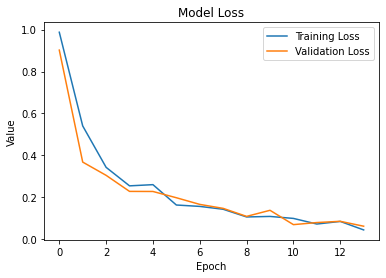

In [47]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


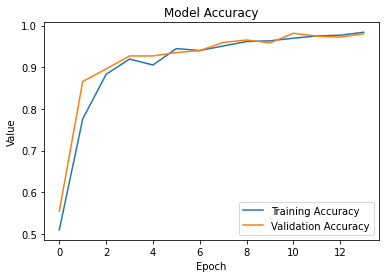

In [48]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

#**Model Utama**

In [49]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Saving 04l5I8TqdzF9WDMJ.png to 04l5I8TqdzF9WDMJ (6).png


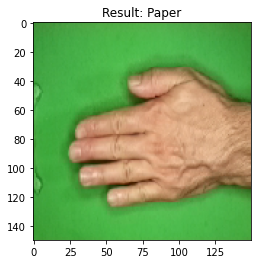

In [54]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # memprediksi gambar
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  resultProb = model.predict(images) 
  resultLabel = resultProb.argmax(axis=-1)

  # meenampilkan gambar berdasarkan class
  if resultLabel == 0:
    plt.title("Result: Paper")
  elif resultLabel == 1:
    plt.title("Result: Rock")
  elif resultLabel == 2:
    plt.title("Result: Scissor")